In [25]:
# CELL 1: Import libraries and setup
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("✅ All libraries loaded successfully!")
print(f"📅 Today is: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ All libraries loaded successfully!
📅 Today is: 2025-12-05 22:37


In [2]:
# CELL 2: Core screening functions

def get_option_chain(ticker):
    """
    Get options chain for a ticker
    """
    try:
        stock = yf.Ticker(ticker)
        expirations = stock.options
        
        if len(expirations) == 0:
            return None
        
        current_price = stock.history(period='1d')['Close'].iloc[-1]
        
        return {
            'ticker': ticker,
            'current_price': current_price,
            'expirations': expirations,
            'stock': stock
        }
    except Exception as e:
        print(f"❌ Error getting data for {ticker}: {e}")
        return None


def find_put_credit_spreads(ticker, 
                            spread_width=5,
                            min_credit=0.30,
                            dte_min=30,
                            dte_max=45,
                            min_volume=50):
    """
    Find put credit spread opportunities for a ticker
    
    Parameters:
    -----------
    ticker : str
        Stock symbol (e.g., 'SPY')
    spread_width : int
        Dollar width of spread (e.g., 5 = $5 wide)
    min_credit : float
        Minimum credit to collect (e.g., 0.30 = $0.30)
    dte_min : int
        Minimum days to expiration
    dte_max : int
        Maximum days to expiration
    min_volume : int
        Minimum option volume for liquidity
    
    Returns:
    --------
    DataFrame of potential spreads
    """
    
    data = get_option_chain(ticker)
    if data is None:
        return pd.DataFrame()
    
    current_price = data['current_price']
    stock = data['stock']
    
    spreads = []
    
    # Loop through expirations
    for exp_date in data['expirations']:
        # Calculate days to expiration
        exp_datetime = datetime.strptime(exp_date, '%Y-%m-%d')
        days_to_exp = (exp_datetime - datetime.now()).days
        
        # Filter by DTE
        if days_to_exp < dte_min or days_to_exp > dte_max:
            continue
        
        try:
            # Get options chain for this expiration
            opt_chain = stock.option_chain(exp_date)
            puts = opt_chain.puts.copy()
            
            # Skip if no data
            if len(puts) == 0:
                continue
            
            # Calculate mid price and spread
            puts['mid'] = (puts['bid'] + puts['ask']) / 2
            puts['spread_pct'] = np.where(
                puts['mid'] > 0,
                ((puts['ask'] - puts['bid']) / puts['mid'] * 100),
                0
            )
            
            # Filter for liquid options
            puts = puts[
                (puts['volume'] >= min_volume) &
                (puts['bid'] > 0) &
                (puts['spread_pct'] < 15)
            ]
            
            # Find spreads
            for idx, short_put in puts.iterrows():
                short_strike = short_put['strike']
                
                # Only look at OTM puts (below current price)
                if short_strike >= current_price * 0.98:  # Within 2% of current
                    continue
                if short_strike < current_price * 0.75:   # More than 25% below
                    continue
                
                # Find corresponding long put
                long_strike = short_strike - spread_width
                long_puts = puts[puts['strike'] == long_strike]
                
                if len(long_puts) == 0:
                    continue
                
                long_put = long_puts.iloc[0]
                
                # Calculate spread metrics
                credit = short_put['bid'] - long_put['ask']
                
                if credit < min_credit:
                    continue
                
                max_profit = credit
                max_loss = spread_width - credit
                
                if max_loss <= 0:
                    continue
                
                # Estimate probability of profit
                # Simple model: distance from current price
                distance_pct = ((current_price - short_strike) / current_price) * 100
                prob_profit = min(0.95, max(0.50, 0.50 + (distance_pct * 0.05)))
                
                # Expected value
                ev = (prob_profit * max_profit) - ((1 - prob_profit) * max_loss)
                
                # Return on risk
                ror = (max_profit / max_loss) * 100
                
                # Breakeven
                breakeven = short_strike - credit
                
                spreads.append({
                    'ticker': ticker,
                    'expiration': exp_date,
                    'dte': days_to_exp,
                    'current_price': current_price,
                    'short_strike': short_strike,
                    'long_strike': long_strike,
                    'width': spread_width,
                    'credit': round(credit, 2),
                    'max_profit': round(max_profit, 2),
                    'max_loss': round(max_loss, 2),
                    'breakeven': round(breakeven, 2),
                    'distance_pct': round(distance_pct, 1),
                    'prob_profit': round(prob_profit, 2),
                    'expected_value': round(ev, 2),
                    'return_on_risk': round(ror, 1),
                    'short_iv': round(short_put['impliedVolatility'] * 100, 1),
                    'short_volume': int(short_put['volume']),
                    'short_oi': int(short_put['openInterest'])
                })
                
        except Exception as e:
            continue
    
    # Convert to DataFrame
    df = pd.DataFrame(spreads)
    
    if len(df) > 0:
        df = df.sort_values('expected_value', ascending=False)
    
    return df


def screen_multiple_tickers(tickers, **kwargs):
    """
    Screen multiple tickers at once
    
    Parameters:
    -----------
    tickers : list
        List of ticker symbols
    **kwargs : 
        Additional parameters to pass to find_put_credit_spreads
    """
    
    all_spreads = []
    
    print(f"🔍 Scanning {len(tickers)} tickers...\n")
    
    for ticker in tickers:
        print(f"  {ticker}...", end=" ")
        
        try:
            spreads = find_put_credit_spreads(ticker, **kwargs)
            
            if len(spreads) > 0:
                all_spreads.append(spreads)
                print(f"✅ {len(spreads)} spreads")
            else:
                print("⚠️  No spreads found")
                
        except Exception as e:
            print(f"❌ Error: {e}")
    
    # Combine results
    if len(all_spreads) > 0:
        final_df = pd.concat(all_spreads, ignore_index=True)
        final_df = final_df.sort_values('expected_value', ascending=False)
        
        print(f"\n{'='*80}")
        print(f"✅ FOUND {len(final_df)} TOTAL OPPORTUNITIES")
        print(f"{'='*80}\n")
        
        return final_df
    
    print("\n❌ No opportunities found\n")
    return pd.DataFrame()


print("✅ Functions loaded successfully!")

✅ Functions loaded successfully!


In [3]:
# CELL 3: Quick test on SPY

print("Testing screener on SPY...\n")

spy_spreads = find_put_credit_spreads(
    'SPY',
    spread_width=5,
    min_credit=0.30,
    dte_min=30,
    dte_max=45
)

if len(spy_spreads) > 0:
    print(f"✅ Found {len(spy_spreads)} SPY spreads!\n")
    print("Top 5 opportunities:")
    print(spy_spreads.head()[['expiration', 'dte', 'short_strike', 'long_strike', 
                               'credit', 'prob_profit', 'expected_value']].to_string(index=False))
else:
    print("❌ No SPY spreads found")

Testing screener on SPY...

✅ Found 13 SPY spreads!

Top 5 opportunities:
expiration  dte  short_strike  long_strike  credit  prob_profit  expected_value
2026-01-16   41         640.0        635.0    0.34         0.83           -0.49
2026-01-16   41         645.0        640.0    0.39         0.80           -0.63
2026-01-09   34         645.0        640.0    0.33         0.80           -0.69
2026-01-16   41         650.0        645.0    0.46         0.76           -0.74
2026-01-09   34         650.0        645.0    0.40         0.76           -0.80


In [4]:
# CELL 4: Screen multiple stocks

# Your watchlist
WATCHLIST = [
    'SPY',   # S&P 500
    'QQQ',   # Nasdaq
    'IWM',   # Russell 2000
    'AAPL',  # Apple
    'MSFT',  # Microsoft
    'NVDA',  # Nvidia
    'AMD',   # AMD
    'TSLA',  # Tesla
    'GOOGL', # Google
    'META',  # Meta
    'AMZN',  # Amazon
]

# Run screener
results = screen_multiple_tickers(
    WATCHLIST,
    spread_width=5,        # $5 wide spreads
    min_credit=0.35,       # Minimum $0.35 credit
    dte_min=30,            # 30-45 days to expiration
    dte_max=45,
    min_volume=100         # Minimum 100 daily volume
)

# Display results
if len(results) > 0:
    print("📊 TOP 10 OPPORTUNITIES:\n")
    
    display_cols = [
        'ticker', 'expiration', 'dte', 'current_price',
        'short_strike', 'long_strike', 'credit', 
        'max_profit', 'max_loss', 'prob_profit',
        'expected_value', 'return_on_risk'
    ]
    
    print(results.head(10)[display_cols].to_string(index=False))

🔍 Scanning 11 tickers...

  SPY... ✅ 7 spreads
  QQQ... ✅ 11 spreads
  IWM... ✅ 7 spreads
  AAPL... ✅ 4 spreads
  MSFT... ✅ 6 spreads
  NVDA... ✅ 17 spreads
  AMD... ✅ 7 spreads
  TSLA... ✅ 25 spreads
  GOOGL... ✅ 6 spreads
  META... ✅ 12 spreads
  AMZN... ✅ 5 spreads

✅ FOUND 107 TOTAL OPPORTUNITIES

📊 TOP 10 OPPORTUNITIES:

ticker expiration  dte  current_price  short_strike  long_strike  credit  max_profit  max_loss  prob_profit  expected_value  return_on_risk
  TSLA 2026-01-16   41     455.000000         415.0        410.0    1.20        1.20      3.80         0.94            0.90            31.6
   AMD 2026-01-16   41     217.970001         200.0        195.0    1.25        1.25      3.75         0.91            0.81            33.3
  TSLA 2026-01-16   41     455.000000         410.0        405.0    1.05        1.05      3.95         0.95            0.80            26.6
   AMD 2026-01-16   41     217.970001         195.0        190.0    1.05        1.05      3.95         0.95     

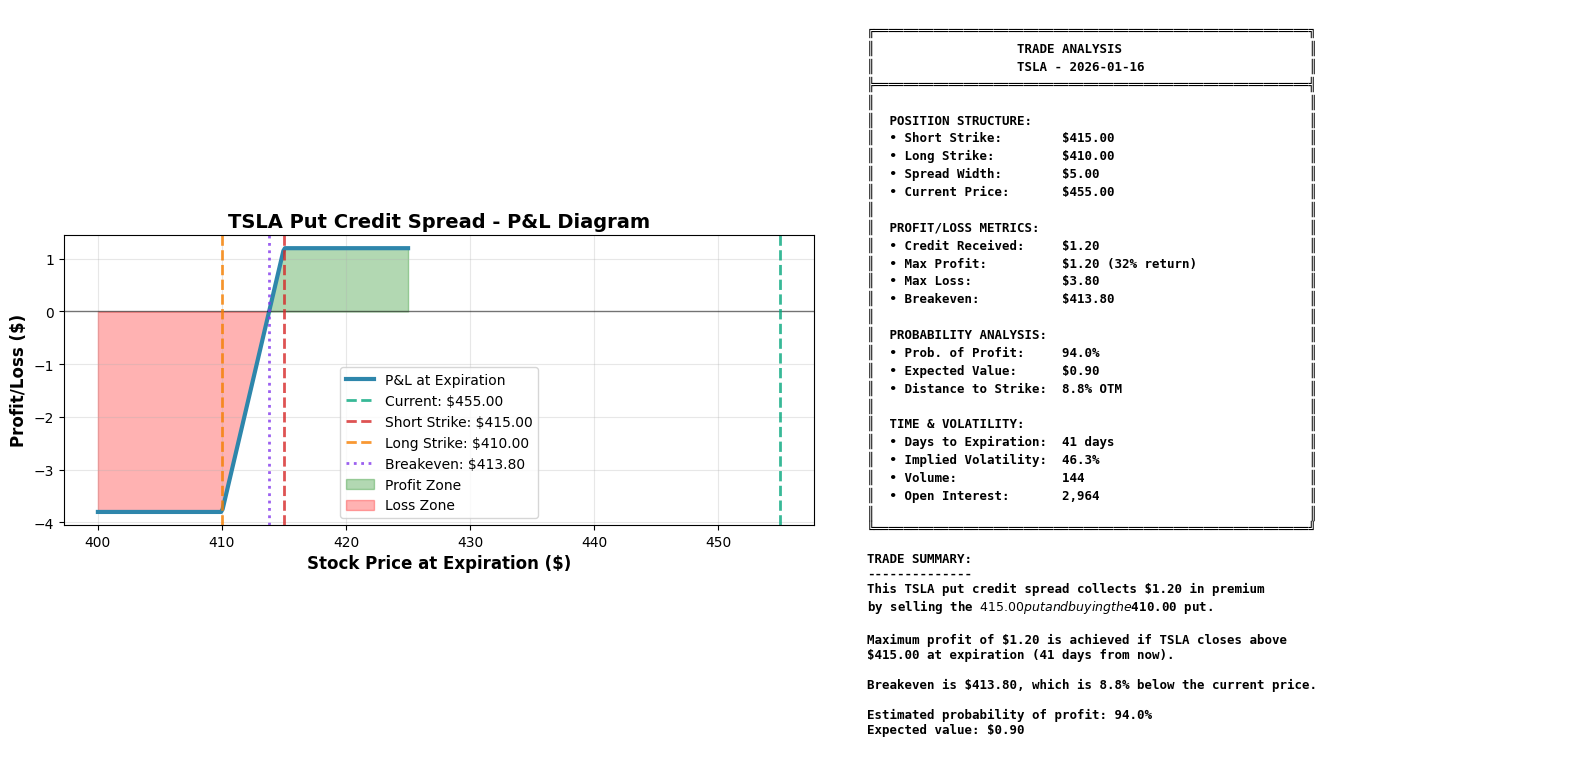

In [23]:
# CELL 5: Visualize the best opportunity

def plot_spread_payoff(spread_data):
    """
    Plot P&L diagram for a credit spread
    """
    
    short_strike = spread_data['short_strike']
    long_strike = spread_data['long_strike']
    credit = spread_data['credit']
    current_price = spread_data['current_price']
    breakeven = spread_data['breakeven']
    
    # Price range for plotting
    price_range = np.linspace(long_strike - 10, short_strike + 10, 200)
    
    # Calculate P&L at each price point
    pnl = []
    for price in price_range:
        if price >= short_strike:
            # Both expire worthless - keep full credit
            pnl.append(credit)
        elif price <= long_strike:
            # Max loss
            pnl.append(credit - (short_strike - long_strike))
        else:
            # Partial loss
            intrinsic = short_strike - price
            pnl.append(credit - intrinsic)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: P&L Diagram
    ax1.plot(price_range, pnl, linewidth=3, color='#2E86AB', label='P&L at Expiration')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax1.axvline(x=current_price, color='#06A77D', linestyle='--', linewidth=2,
                label=f'Current: ${current_price:.2f}', alpha=0.8)
    ax1.axvline(x=short_strike, color='#D62828', linestyle='--', linewidth=2,
                label=f'Short Strike: ${short_strike:.2f}', alpha=0.8)
    ax1.axvline(x=long_strike, color='#F77F00', linestyle='--', linewidth=2,
                label=f'Long Strike: ${long_strike:.2f}', alpha=0.8)
    ax1.axvline(x=breakeven, color='#8338EC', linestyle=':', linewidth=2,
                label=f'Breakeven: ${breakeven:.2f}', alpha=0.8)
    
    # Fill profit/loss areas
    ax1.fill_between(price_range, 0, pnl, where=(np.array(pnl) > 0),
                     alpha=0.3, color='green', label='Profit Zone')
    ax1.fill_between(price_range, 0, pnl, where=(np.array(pnl) <= 0),
                     alpha=0.3, color='red', label='Loss Zone')
    
    ax1.set_xlabel('Stock Price at Expiration ($)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Profit/Loss ($)', fontsize=12, fontweight='bold')
    ax1.set_title(f"{spread_data['ticker']} Put Credit Spread - P&L Diagram", 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Trade Stats
    ax2.axis('off')
    
    stats_text = f"""
╔══════════════════════════════════════════════════════════╗
║                   TRADE ANALYSIS                         ║
║                   {spread_data['ticker']} - {spread_data['expiration']}                      ║
╠══════════════════════════════════════════════════════════╣
║                                                          ║
║  POSITION STRUCTURE:                                     ║
║  • Short Strike:        ${spread_data['short_strike']:.2f}                          ║
║  • Long Strike:         ${spread_data['long_strike']:.2f}                          ║
║  • Spread Width:        ${spread_data['width']:.2f}                            ║
║  • Current Price:       ${spread_data['current_price']:.2f}                          ║
║                                                          ║
║  PROFIT/LOSS METRICS:                                    ║
║  • Credit Received:     ${spread_data['credit']:.2f}                            ║
║  • Max Profit:          ${spread_data['max_profit']:.2f} ({spread_data['return_on_risk']:.0f}% return)               ║
║  • Max Loss:            ${spread_data['max_loss']:.2f}                            ║
║  • Breakeven:           ${spread_data['breakeven']:.2f}                          ║
║                                                          ║
║  PROBABILITY ANALYSIS:                                   ║
║  • Prob. of Profit:     {spread_data['prob_profit']*100:.1f}%                            ║
║  • Expected Value:      ${spread_data['expected_value']:.2f}                            ║
║  • Distance to Strike:  {spread_data['distance_pct']:.1f}% OTM                         ║
║                                                          ║
║  TIME & VOLATILITY:                                      ║
║  • Days to Expiration:  {spread_data['dte']} days                          ║
║  • Implied Volatility:  {spread_data['short_iv']:.1f}%                            ║
║  • Volume:              {spread_data['short_volume']:,}                              ║
║  • Open Interest:       {spread_data['short_oi']:,}                            ║
║                                                          ║
╚══════════════════════════════════════════════════════════╝

TRADE SUMMARY:
--------------
This {spread_data['ticker']} put credit spread collects ${spread_data['credit']:.2f} in premium
by selling the ${spread_data['short_strike']:.2f} put and buying the ${spread_data['long_strike']:.2f} put.

Maximum profit of ${spread_data['max_profit']:.2f} is achieved if {spread_data['ticker']} closes above
${spread_data['short_strike']:.2f} at expiration ({spread_data['dte']} days from now).

Breakeven is ${spread_data['breakeven']:.2f}, which is {spread_data['distance_pct']:.1f}% below the current price.

Estimated probability of profit: {spread_data['prob_profit']*100:.1f}%
Expected value: ${spread_data['expected_value']:.2f}
    """
    
    ax2.text(0.05, 0.5, stats_text, fontsize=9, family='monospace',
             verticalalignment='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# Plot the best opportunity
if len(results) > 0:
    best_trade = results.iloc[0]
    plot_spread_payoff(best_trade)
else:
    print("No results to plot")

In [26]:
# CELL 6: Save results to Excel

def save_results(df, filename=None):
    """
    Save screening results to Excel
    """
    if len(df) == 0:
        print("❌ No results to save")
        return
    
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'screener_results_{timestamp}.xlsx'
    
    # Create Excel writer
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Save all results
        df.to_excel(writer, sheet_name='All Spreads', index=False)
        
        # Save summary by ticker
        summary = df.groupby('ticker').agg({
            'expected_value': 'mean',
            'prob_profit': 'mean',
            'return_on_risk': 'mean',
            'ticker': 'count'
        }).rename(columns={'ticker': 'num_opportunities'})
        summary.to_excel(writer, sheet_name='Summary by Ticker')
    
    print(f"✅ Saved {len(df)} results to: {filename}")
    print(f"📂 Location: {os.path.abspath(filename)}")

# Save results
if len(results) > 0:
    save_results(results)

✅ Saved 107 results to: screener_results_20251205_223709.xlsx
📂 Location: c:\Users\Vince\options_screener\screener_results_20251205_223709.xlsx


In [27]:
# CELL 7: Your custom screener with adjustable parameters

def my_screener(
    # Tickers to scan
    tickers=['SPY', 'QQQ', 'IWM'],
    
    # Spread parameters
    spread_width=5,           # Width between strikes
    min_credit=0.30,          # Minimum premium to collect
    
    # Time parameters
    dte_min=30,               # Minimum days to expiration
    dte_max=45,               # Maximum days to expiration
    
    # Quality filters
    min_prob_profit=0.65,     # Minimum probability of profit
    min_expected_value=0.10,  # Minimum expected value
    min_return_on_risk=15,    # Minimum ROR %
    
    # Liquidity filters
    min_volume=100,           # Minimum option volume
    min_open_interest=500,    # Minimum open interest
):
    """
    🎯 YOUR CUSTOM SCREENER
    
    Adjust parameters above to find trades matching YOUR criteria!
    """
    
    print("="*80)
    print("🎯 CUSTOM SCREENER")
    print("="*80)
    print(f"\nParameters:")
    print(f"  Tickers: {len(tickers)}")
    print(f"  Spread Width: ${spread_width}")
    print(f"  Min Credit: ${min_credit}")
    print(f"  DTE Range: {dte_min}-{dte_max} days")
    print(f"  Min Prob Profit: {min_prob_profit*100:.0f}%")
    print(f"  Min EV: ${min_expected_value}")
    print(f"  Min ROR: {min_return_on_risk}%")
    print(f"\n{'='*80}\n")
    
    # Run screener
    results = screen_multiple_tickers(
        tickers,
        spread_width=spread_width,
        min_credit=min_credit,
        dte_min=dte_min,
        dte_max=dte_max,
        min_volume=min_volume
    )
    
    # Apply filters
    if len(results) > 0:
        filtered = results[
            (results['prob_profit'] >= min_prob_profit) &
            (results['expected_value'] >= min_expected_value) &
            (results['return_on_risk'] >= min_return_on_risk) &
            (results['short_oi'] >= min_open_interest)
        ]
        
        print(f"\n{'='*80}")
        print(f"📊 RESULTS: {len(filtered)} trades match your criteria")
        print(f"{'='*80}\n")
        
        if len(filtered) > 0:
            print(filtered.head(15)[['ticker', 'expiration', 'dte', 'short_strike',
                                     'credit', 'prob_profit', 'expected_value',
                                     'return_on_risk']].to_string(index=False))
            return filtered
        else:
            print("❌ No trades match all filters. Try loosening criteria.")
    
    return pd.DataFrame()


# RUN YOUR CUSTOM SCREENER
custom_results = my_screener(
    tickers=['SPY', 'QQQ', 'IWM', 'AAPL', 'MSFT', 'NVDA', 'AMD', 'TSLA'],
    spread_width=5,
    min_credit=0.40,
    dte_min=35,
    dte_max=45,
    min_prob_profit=0.70,
    min_expected_value=0.15,
    min_return_on_risk=20,
    min_volume=150,
    min_open_interest=1000
)

🎯 CUSTOM SCREENER

Parameters:
  Tickers: 8
  Spread Width: $5
  Min Credit: $0.4
  DTE Range: 35-45 days
  Min Prob Profit: 70%
  Min EV: $0.15
  Min ROR: 20%


🔍 Scanning 8 tickers...

  SPY... ✅ 5 spreads
  QQQ... ✅ 5 spreads
  IWM... ✅ 5 spreads
  AAPL... ✅ 3 spreads
  MSFT... ✅ 4 spreads
  NVDA... ✅ 11 spreads
  AMD... ✅ 5 spreads
  TSLA... ✅ 11 spreads

✅ FOUND 49 TOTAL OPPORTUNITIES


📊 RESULTS: 12 trades match your criteria

ticker expiration  dte  short_strike  credit  prob_profit  expected_value  return_on_risk
   AMD 2026-01-16   41         200.0    1.25         0.91            0.81            33.3
   AMD 2026-01-16   41         195.0    1.05         0.95            0.80            26.6
  TSLA 2026-01-16   41         410.0    1.05         0.95            0.80            26.6
  TSLA 2026-01-16   41         405.0    0.90         0.95            0.65            22.0
  TSLA 2026-01-16   41         425.0    1.50         0.83            0.65            42.9
  NVDA 2026-01-16   41 

In [28]:
# CELL 8: Advanced Pricing Models

from scipy.stats import norm
import numpy as np

class BlackScholesCalculator:
    """
    Professional-grade Black-Scholes option pricing
    """
    
    def __init__(self, S, K, T, r, sigma, option_type='call'):
        """
        S: Current stock price
        K: Strike price
        T: Time to expiration (in years)
        r: Risk-free rate
        sigma: Implied volatility (annual)
        """
        self.S = S
        self.K = K
        self.T = T
        self.r = r
        self.sigma = sigma
        self.option_type = option_type.lower()
    
    def d1(self):
        """Calculate d1 component"""
        return (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
    
    def d2(self):
        """Calculate d2 component"""
        return self.d1() - self.sigma * np.sqrt(self.T)
    
    def price(self):
        """Calculate option price"""
        d1 = self.d1()
        d2 = self.d2()
        
        if self.option_type == 'call':
            price = self.S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        else:  # put
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
        
        return price
    
    def delta(self):
        """Calculate delta (rate of change with respect to underlying)"""
        if self.option_type == 'call':
            return norm.cdf(self.d1())
        else:  # put
            return -norm.cdf(-self.d1())
    
    def gamma(self):
        """Calculate gamma (rate of change of delta)"""
        return norm.pdf(self.d1()) / (self.S * self.sigma * np.sqrt(self.T))
    
    def vega(self):
        """Calculate vega (sensitivity to volatility)"""
        return self.S * norm.pdf(self.d1()) * np.sqrt(self.T) / 100  # Divided by 100 for 1% change
    
    def theta(self):
        """Calculate theta (time decay per day)"""
        d1 = self.d1()
        d2 = self.d2()
        
        if self.option_type == 'call':
            theta = (-self.S * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T)) 
                    - self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(d2))
        else:  # put
            theta = (-self.S * norm.pdf(d1) * self.sigma / (2 * np.sqrt(self.T)) 
                    + self.r * self.K * np.exp(-self.r * self.T) * norm.cdf(-d2))
        
        return theta / 365  # Per day
    
    def rho(self):
        """Calculate rho (sensitivity to interest rate)"""
        d2 = self.d2()
        
        if self.option_type == 'call':
            return self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(d2) / 100
        else:  # put
            return -self.K * self.T * np.exp(-self.r * self.T) * norm.cdf(-d2) / 100
    
    def all_greeks(self):
        """Return all Greeks at once"""
        return {
            'price': self.price(),
            'delta': self.delta(),
            'gamma': self.gamma(),
            'vega': self.vega(),
            'theta': self.theta(),
            'rho': self.rho()
        }


# Example usage
bs = BlackScholesCalculator(
    S=450,      # SPY at $450
    K=445,      # $445 strike
    T=45/365,   # 45 days to expiration
    r=0.05,     # 5% risk-free rate
    sigma=0.15, # 15% implied volatility
    option_type='put'
)

greeks = bs.all_greeks()
print("Black-Scholes Calculation:")
print(f"  Price: ${greeks['price']:.2f}")
print(f"  Delta: {greeks['delta']:.4f}")
print(f"  Gamma: {greeks['gamma']:.4f}")
print(f"  Vega: ${greeks['vega']:.2f}")
print(f"  Theta: ${greeks['theta']:.2f} per day")

Black-Scholes Calculation:
  Price: $6.01
  Delta: -0.3611
  Gamma: 0.0158
  Vega: $0.59
  Theta: $-0.08 per day


Monte Carlo Analysis:
  Expected Value: $-0.77
  Probability of Profit: 62.7%
  Sharpe Ratio: -0.33
  95% VaR: $-4.00


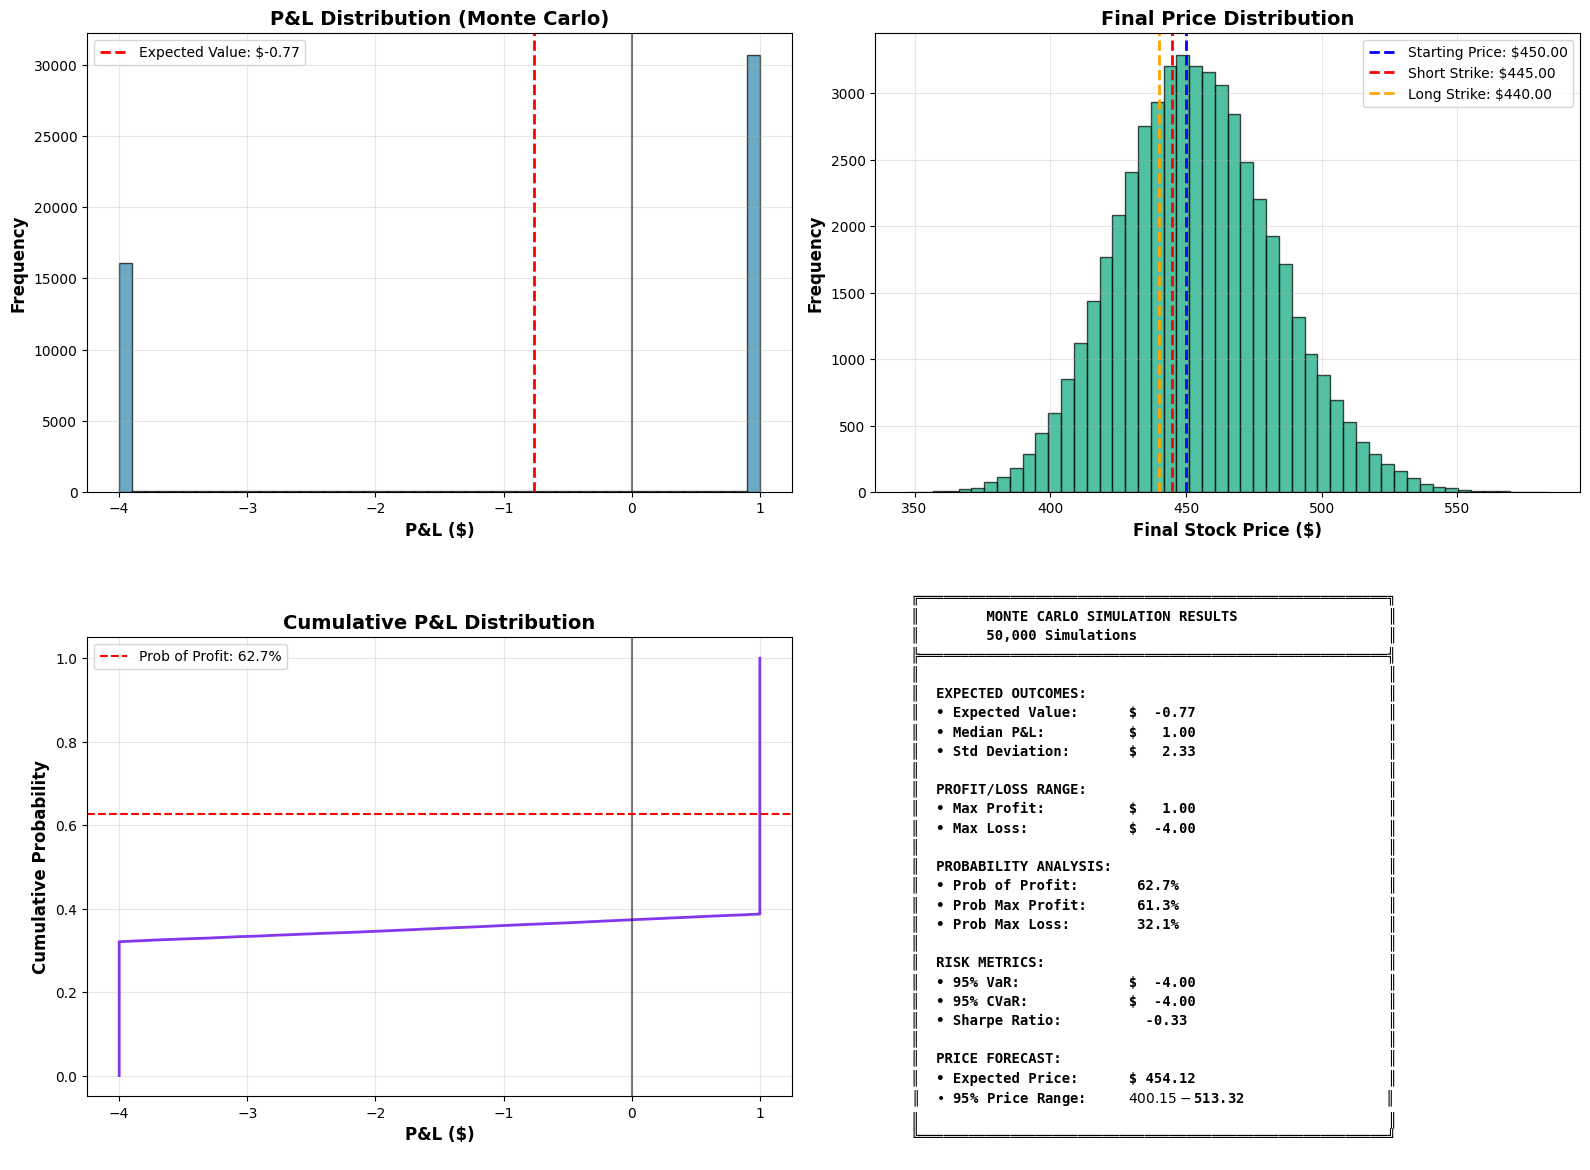

In [49]:
# CELL 9: Monte Carlo Spread Simulator

class MonteCarloSpreadSimulator:
    """
    Simulate credit spread outcomes using Monte Carlo
    """
    
    def __init__(self, current_price, volatility, risk_free_rate=0.05):
        self.S0 = current_price
        self.sigma = volatility
        self.r = risk_free_rate
    
    def simulate_paths(self, days, n_simulations=10000):
        """
        Simulate stock price paths using Geometric Brownian Motion
        """
        dt = 1/252  # Daily time step
        n_steps = days
        
        # Preallocate array
        paths = np.zeros((n_simulations, n_steps + 1))
        paths[:, 0] = self.S0
        
        # Generate all random numbers at once (faster)
        Z = np.random.standard_normal((n_simulations, n_steps))
        
        # Simulate paths
        for t in range(1, n_steps + 1):
            paths[:, t] = paths[:, t-1] * np.exp(
                (self.r - 0.5 * self.sigma**2) * dt + 
                self.sigma * np.sqrt(dt) * Z[:, t-1]
            )
        
        return paths
    
    def analyze_put_credit_spread(self, short_strike, long_strike, 
                                   credit, days_to_exp, n_simulations=10000):
        """
        Analyze put credit spread with Monte Carlo
        """
        # Simulate price paths
        paths = self.simulate_paths(days_to_exp, n_simulations)
        final_prices = paths[:, -1]
        
        # Calculate P&L for each path
        pnl = np.zeros(n_simulations)
        spread_width = short_strike - long_strike
        
        for i, S_T in enumerate(final_prices):
            if S_T >= short_strike:
                # Both expire worthless - keep full credit
                pnl[i] = credit
            elif S_T <= long_strike:
                # Max loss
                pnl[i] = credit - spread_width
            else:
                # Partial loss
                intrinsic = short_strike - S_T
                pnl[i] = credit - intrinsic
        
        # Calculate statistics
        results = {
            'simulations': n_simulations,
            'final_prices': final_prices,
            'pnl': pnl,
            
            # P&L Statistics
            'expected_value': np.mean(pnl),
            'median_pnl': np.median(pnl),
            'std_pnl': np.std(pnl),
            'max_profit': credit,
            'max_loss': credit - spread_width,
            
            # Probability Metrics
            'prob_profit': np.sum(pnl > 0) / n_simulations,
            'prob_max_profit': np.sum(pnl == credit) / n_simulations,
            'prob_max_loss': np.sum(pnl == (credit - spread_width)) / n_simulations,
            
            # Risk Metrics
            'var_95': np.percentile(pnl, 5),  # 95% Value at Risk
            'cvar_95': np.mean(pnl[pnl <= np.percentile(pnl, 5)]),  # Conditional VaR
            'sharpe_ratio': np.mean(pnl) / np.std(pnl) if np.std(pnl) > 0 else 0,
            
            # Price Distribution
            'avg_final_price': np.mean(final_prices),
            'median_final_price': np.median(final_prices),
            'price_range_95': (np.percentile(final_prices, 2.5), np.percentile(final_prices, 97.5))
        }
        
        return results
    
    def plot_simulation_results(self, results, spread_info):
        """
        Visualize Monte Carlo results
        """
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. P&L Distribution
        ax = axes[0, 0]
        ax.hist(results['pnl'], bins=50, alpha=0.7, edgecolor='black', color='#2E86AB')
        ax.axvline(results['expected_value'], color='red', linestyle='--', linewidth=2,
                   label=f"Expected Value: ${results['expected_value']:.2f}")
        ax.axvline(0, color='black', linestyle='-', alpha=0.5)
        ax.set_xlabel('P&L ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title('P&L Distribution (Monte Carlo)', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Final Price Distribution
        ax = axes[0, 1]
        ax.hist(results['final_prices'], bins=50, alpha=0.7, edgecolor='black', color='#06A77D')
        ax.axvline(self.S0, color='blue', linestyle='--', linewidth=2,
                   label=f"Starting Price: ${self.S0:.2f}")
        ax.axvline(spread_info['short_strike'], color='red', linestyle='--', linewidth=2,
                   label=f"Short Strike: ${spread_info['short_strike']:.2f}")
        ax.axvline(spread_info['long_strike'], color='orange', linestyle='--', linewidth=2,
                   label=f"Long Strike: ${spread_info['long_strike']:.2f}")
        ax.set_xlabel('Final Stock Price ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
        ax.set_title('Final Price Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Cumulative P&L
        ax = axes[1, 0]
        sorted_pnl = np.sort(results['pnl'])
        cumulative = np.arange(1, len(sorted_pnl) + 1) / len(sorted_pnl)
        ax.plot(sorted_pnl, cumulative, linewidth=2, color='#8338EC')
        ax.axvline(0, color='black', linestyle='-', alpha=0.5)
        ax.axhline(results['prob_profit'], color='red', linestyle='--',
                   label=f"Prob of Profit: {results['prob_profit']:.1%}")
        ax.set_xlabel('P&L ($)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Cumulative Probability', fontsize=12, fontweight='bold')
        ax.set_title('Cumulative P&L Distribution', fontsize=14, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Statistics Table
        ax = axes[1, 1]
        ax.axis('off')
        
        stats_text = f"""
╔════════════════════════════════════════════════════════╗
║        MONTE CARLO SIMULATION RESULTS                  ║
║        {results['simulations']:,} Simulations                              ║
╠════════════════════════════════════════════════════════╣
║                                                        ║
║  EXPECTED OUTCOMES:                                    ║
║  • Expected Value:      ${results['expected_value']:>7.2f}                       ║
║  • Median P&L:          ${results['median_pnl']:>7.2f}                       ║
║  • Std Deviation:       ${results['std_pnl']:>7.2f}                       ║
║                                                        ║
║  PROFIT/LOSS RANGE:                                    ║
║  • Max Profit:          ${results['max_profit']:>7.2f}                       ║
║  • Max Loss:            ${results['max_loss']:>7.2f}                       ║
║                                                        ║
║  PROBABILITY ANALYSIS:                                 ║
║  • Prob of Profit:      {results['prob_profit']:>6.1%}                         ║
║  • Prob Max Profit:     {results['prob_max_profit']:>6.1%}                         ║
║  • Prob Max Loss:       {results['prob_max_loss']:>6.1%}                         ║
║                                                        ║
║  RISK METRICS:                                         ║
║  • 95% VaR:             ${results['var_95']:>7.2f}                       ║
║  • 95% CVaR:            ${results['cvar_95']:>7.2f}                       ║
║  • Sharpe Ratio:        {results['sharpe_ratio']:>7.2f}                        ║
║                                                        ║
║  PRICE FORECAST:                                       ║
║  • Expected Price:      ${results['avg_final_price']:>7.2f}                       ║
║  • 95% Price Range:     ${results['price_range_95'][0]:>6.2f} - ${results['price_range_95'][1]:<6.2f}                 ║
║                                                        ║
╚════════════════════════════════════════════════════════╝
        """
        
        ax.text(0.05, 0.5, stats_text, fontsize=10, family='monospace',
                verticalalignment='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()


# Example: Run Monte Carlo on a spread
simulator = MonteCarloSpreadSimulator(
    current_price=450,
    volatility=0.15,  # 15% annual vol
    risk_free_rate=0.05
)

mc_results = simulator.analyze_put_credit_spread(
    short_strike=445,
    long_strike=440,
    credit=1.00,
    days_to_exp=45,
    n_simulations=50000  # More simulations = more accurate
)

print(f"Monte Carlo Analysis:")
print(f"  Expected Value: ${mc_results['expected_value']:.2f}")
print(f"  Probability of Profit: {mc_results['prob_profit']:.1%}")
print(f"  Sharpe Ratio: {mc_results['sharpe_ratio']:.2f}")
print(f"  95% VaR: ${mc_results['var_95']:.2f}")

# Plot results
simulator.plot_simulation_results(mc_results, {
    'short_strike': 445,
    'long_strike': 440
})

In [50]:
# CELL 10: IV Rank & Percentile

def calculate_iv_rank(ticker, current_iv, lookback_days=252):
    """
    Calculate IV Rank and IV Percentile
    
    IV Rank = (Current IV - Min IV) / (Max IV - Min IV) * 100
    IV Percentile = % of days IV was below current level
    """
    try:
        stock = yf.Ticker(ticker)
        
        # Get historical options data (limited with free API)
        # In production, you'd use ORATS or similar
        
        # For now, use historical volatility as proxy
        hist = stock.history(period='1y')
        returns = hist['Close'].pct_change().dropna()
        
        # Calculate rolling 30-day realized volatility
        rolling_vol = returns.rolling(window=30).std() * np.sqrt(252)
        
        min_vol = rolling_vol.min()
        max_vol = rolling_vol.max()
        
        # IV Rank
        iv_rank = ((current_iv - min_vol) / (max_vol - min_vol)) * 100
        
        # IV Percentile
        iv_percentile = (rolling_vol < current_iv).sum() / len(rolling_vol) * 100
        
        return {
            'iv_rank': iv_rank,
            'iv_percentile': iv_percentile,
            'current_iv': current_iv,
            'min_iv_1y': min_vol,
            'max_iv_1y': max_vol,
            'mean_iv_1y': rolling_vol.mean()
        }
        
    except Exception as e:
        return None


# Example
iv_data = calculate_iv_rank('SPY', current_iv=0.15)
if iv_data:
    print(f"IV Analysis for SPY:")
    print(f"  Current IV: {iv_data['current_iv']:.1%}")
    print(f"  IV Rank: {iv_data['iv_rank']:.1f}")
    print(f"  IV Percentile: {iv_data['iv_percentile']:.1f}")
    print(f"  1Y Range: {iv_data['min_iv_1y']:.1%} - {iv_data['max_iv_1y']:.1%}")

IV Analysis for SPY:
  Current IV: 15.0%
  IV Rank: 21.4
  IV Percentile: 59.0
  1Y Range: 6.7% - 45.5%


In [ ]:
# CELL 6: Save results to Excel

def save_results(df, filename=None):
    """
    Save screening results to Excel
    """
    if len(df) == 0:
        print("❌ No results to save")
        return
    
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f'screener_results_{timestamp}.xlsx'
    
    # Create Excel writer
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # Save all results
        df.to_excel(writer, sheet_name='All Spreads', index=False)
        
        # Save summary by ticker
        summary = df.groupby('ticker').agg({
            'expected_value': 'mean',
            'prob_profit': 'mean',
            'return_on_risk': 'mean',
            'ticker': 'count'
        }).rename(columns={'ticker': 'num_opportunities'})
        summary.to_excel(writer, sheet_name='Summary by Ticker')
    
    print(f"✅ Saved {len(df)} results to: {filename}")
    print(f"📂 Location: {os.path.abspath(filename)}")

# Save results
if len(results) > 0:
    save_results(results)

✅ Saved 107 results to: screener_results_20251205_223709.xlsx
📂 Location: c:\Users\Vince\options_screener\screener_results_20251205_223709.xlsx
